In [19]:
import numpy as np
from scipy import special as sp
from common.baseclasses import ArrayWithAxes as AWA
import matplotlib.pyplot as plt

In [20]:
class Translator:
    """
        Generator of Bessel functions placed at arbitrary "center" position
        within an xy mesh space.  Works by generating a bessel function on
        a much larger xy mesh and then translating/truncating to the
        original mesh.  Nothing fancy, but good for performance.
    """

    def __init__(self,q=20, \
                 xs=np.linspace(-1,1,101), \
                 ys=np.linspace(-1,1,101),
                 f = lambda x,y: sp.jv(0,np.sqrt(x**2+y**2))):

        self.f = f

        #Bookkeeping of the coordinate mesh
        self.xs,self.ys=xs,ys
        self.shape=(len(xs),len(ys))
        self.midx=self.xs[self.shape[0]//2]
        self.midy=self.ys[self.shape[1]//2]
        self.dx=np.max(self.xs)-np.min(self.xs)
        self.dy=np.max(self.ys)-np.min(self.ys)

        #Make a mesh grid twice bigger in each direction
        bigshape=[2*N-1 for N in self.shape]
        xs2grid,ys2grid=np.ogrid[-self.dx:+self.dx:bigshape[0]*1j,
                                 -self.dy:+self.dy:bigshape[1]*1j]

        self.bigJ = self.f(xs2grid,ys2grid)

    def __call__(self,x0,y0):
        shift_by_dx=x0-self.midx
        shift_by_dy=y0-self.midy
        shift_by_nx=int(self.shape[0]*shift_by_dx/self.dx)
        shift_by_ny=int(self.shape[1]*shift_by_dy/self.dy)
        newJ=np.roll(np.roll(self.bigJ,shift_by_nx,axis=0),\
                     shift_by_ny,axis=1)
        output = newJ[self.shape[0]//2:(3*self.shape[0])//2,\
                     self.shape[1]//2:(3*self.shape[1])//2]
        return AWA(output,axes=[self.xs,self.ys])


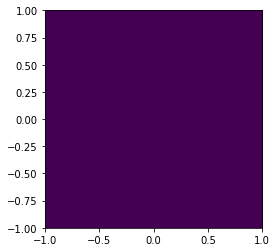

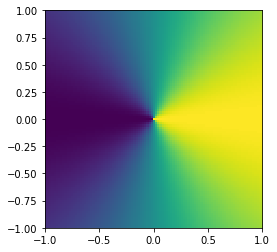

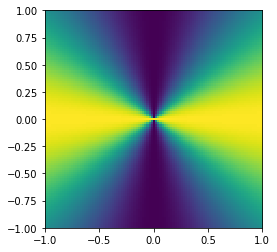

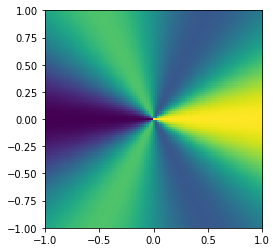

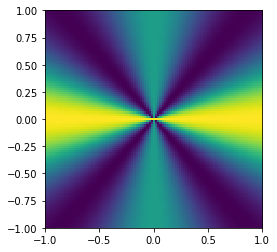

In [44]:
def tester():
    def mybessel(v,A,Q,x,y):
        r = np.sqrt(x**2+y**2)
        theta = np.arctan2(x,y)
        return A*sp.jv(v,Q*r)*np.cos(theta)

    def planewave(qx,qy,x,y):
        return np.sin(qx*x+qy*y)

    def spherical_harmonic(m,n,x,y):
        theta = np.arctan2(x,y)
        phi = np.pi/4
        return sp.sph_harm(m,n,phi,theta)

    N=5
    q=20

    for n in range(0,N):
        q_prefactor = (2*q*(n+1)/(N+1))**2
        exp_prefactor = np.exp(-2*(n+1)/(N+1))
        A = q_prefactor*exp_prefactor
        Q = (2*q*(n+1)/(N+1))

        func = lambda x,y: np.real(spherical_harmonic(0,n,x,y))
        #func = lambda x,y: mybessel(0,A,Q,x,y)
        #func = lambda x,y: planewave(0,2,x,y)

        gen = Translator(xs=np.linspace(-1,1,101), ys=np.linspace(-1,1,101),f=func)
        plt.figure()
        plt.imshow(gen(0,0), extent = [-1,1,-1,1], origin='bottom')
        plt.show()